In [1]:
import mahotas
import mahotas.features
from glob import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp
from statsmodels.formula.api import ols
%matplotlib inline

In [ ]:
inDataDir = '211008_CellProfilerOutput'
outDataDir = '.'

In [3]:
images = {} #do not end up in the same order - need to fix this.

images['DNA'] = glob(f'{inDataDir}/Nuclei_Images_DNA_Slide*/*', recursive = True)

images['Top2A'] = []

for i in images['DNA']:
    images['Top2A'].append(i.replace('DNA', 'Top2A'))


In [4]:
#read in images

imported_images = {}

for stain in ['DNA', 'Top2A']:
    imported_images[stain] = {}
    for image in images[stain]:
        imported_images[stain][image] = mahotas.imread(image)

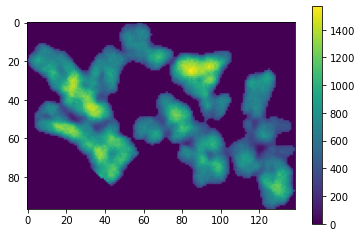

In [5]:
plt.imshow(imported_images['DNA']['211008_CellProfilerOutput/Nuclei_Images_DNA_Slide4_001/Nuclei_1.tiff'])
plt.colorbar()

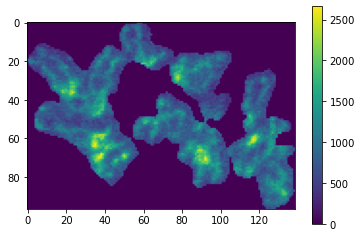

In [6]:
plt.imshow(imported_images['Top2A']['211008_CellProfilerOutput/Nuclei_Images_Top2A_Slide4_001/Nuclei_1.tiff'])
plt.colorbar()

In [7]:
#stretch images to 256 levels each, min to max

stretched_images = {}

for stain in ['DNA', 'Top2A']:
    stretched_images[stain] = {}
    for image in images[stain]:
        stretched_images[stain][image] = mahotas.stretch(imported_images[stain][image])

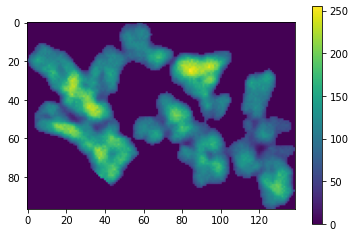

In [8]:
plt.imshow(stretched_images['DNA']['211008_CellProfilerOutput/Nuclei_Images_DNA_Slide4_001/Nuclei_1.tiff'])
plt.colorbar()

#scaled to 255 total levels, using 0 and max of image as min and max possible

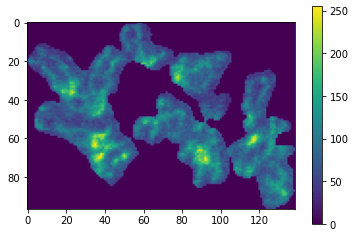

In [9]:
plt.imshow(stretched_images['Top2A']['211008_CellProfilerOutput/Nuclei_Images_Top2A_Slide4_001/Nuclei_1.tiff'])
plt.colorbar()

#scaled to 255 total levels, using 0 and max of image as min and max possible

In [10]:
image_features = pd.DataFrame()

for size in range(1, 25):
    image_features_df_dict = {}
    
    image_features_df_dict['DNA'] = pd.DataFrame()
    image_features_df_dict['Top2A'] = pd.DataFrame()
    
    for stain in ['DNA', 'Top2A']:
        image_features_df = pd.DataFrame()
        for image in images[stain]:
            df = pd.DataFrame(mahotas.features.haralick(stretched_images[stain][image], return_mean = True, distance = size, ignore_zeros = True)).transpose()
            df.columns = [
                f'AngularSecondMoment_{stain}',
                f'Contrast_{stain}',
                f'Correlation_{stain}',
                f'Variance_{stain}',
                f'InverseDifferenceMoment_{stain}',
                f'SumAverage_{stain}',
                f'SumVariance_{stain}',
                f'SumEntropy_{stain}',
                f'Entropy_{stain}',
                f'DifferenceVariance_{stain}',
                f'DifferenceEntropy_{stain}',
                f'InfoMeas1_{stain}',
                f'InfoMeas2_{stain}'
            ]
            df[f'ImagePath_{stain}'] = image
            df[f'Distance_{stain}'] = size
            #Split filename at /, then split SlideDir 
            df[['InputDir', 'ImageDir', 'FileName']] = df[f'ImagePath_{stain}'].str.split('/', expand=True).iloc[:, 0:3]
            df[['Stain', 'SlideNum', 'ImageNum']] = df['ImageDir'].str.split('_', expand = True).iloc[:, 2:5]

            #Add sample name for each nucleus based on slide number
            #Cell Line: HeLa S3 + Top2A-Venus, or HeLa S3 untagged

            #Samples:
            #1. Hela S3, Top2A-Venus, t4 DMSO, DAPI
            #2. Hela S3, Top2A-Venus, t4 DMSO, DAPI, Lamin A
            #4. HeLa S3, Top2A-Venus, t0 Mit, DAPI, Lamin A
            #5. HeLa S3, Top2A-Venus, t2, DAPI, Lamin A
            #6. HeLa S3, Top2A-Venus, t4 DMSO, DAPI, Lamin A
            #7. HeLa S3, Top2A-Venus, t4 ICRF, DAPI, Lamin A
            #8. HeLa S3, Top2A-Venus, t8 DMSO, DAPI, Lamin A
            #9. HeLa S3, Top2A-Venus, t8 ICRF, DAPI, Lamin A

            slidenum_samples = {
                'Slide1' : 'No Lamin A',
                'Slide2' : 't4 DMSO slide 1',
                'Slide4' : 't0 Mitotic',
                'Slide5' : 't2',
                'Slide6' : 't4 DMSO slide 2',
                'Slide7' : 't4 ICRF-193',
                'Slide8' : 't8 DMSO',
                'Slide9' : 't8 ICRF-193'
            }

            for slide in df['SlideNum'].unique():
                df.loc[df['SlideNum'] == slide, 'Sample'] = slidenum_samples[slide]

            image_features_df_dict[stain] = image_features_df_dict[stain].append(df)
            
    size_df = image_features_df_dict['DNA'].merge(image_features_df_dict['Top2A'], on = ['Sample', 'SlideNum', 'FileName', 'ImageNum'], suffixes = ('_DNA', '_Top2A'))
    image_features = image_features.append(size_df).reset_index(drop = True)

In [11]:
image_features[['ImageDir_DNA', 'ImageDir_Top2A', 'Sample', 'SlideNum', 'FileName', 'ImageNum']]

,ImageDir_DNA,ImageDir_Top2A,Sample,SlideNum,FileName,ImageNum
0,Nuclei_Images_DNA_Slide2_022,Nuclei_Images_Top2A_Slide2_022,t4 DMSO slide 1,Slide2,Nuclei_2.tiff,022
1,Nuclei_Images_DNA_Slide2_022,Nuclei_Images_Top2A_Slide2_022,t4 DMSO slide 1,Slide2,Nuclei_1.tiff,022
2,Nuclei_Images_DNA_Slide2_025,Nuclei_Images_Top2A_Slide2_025,t4 DMSO slide 1,Slide2,Nuclei_2.tiff,025
3,Nuclei_Images_DNA_Slide2_025,Nuclei_Images_Top2A_Slide2_025,t4 DMSO slide 1,Slide2,Nuclei_1.tiff,025
4,Nuclei_Images_DNA_Slide2_013,Nuclei_Images_Top2A_Slide2_013,t4 DMSO slide 1,Slide2,Nuclei_3.tiff,013
...,...,...,...,...,...,...
12307,Nuclei_Images_DNA_Slide2_004,Nuclei_Images_Top2A_Slide2_004,t4 DMSO slide 1,Slide2,Nuclei_3.tiff,004
12308,Nuclei_Images_DNA_Slide2_004,Nuclei_Images_Top2A_Slide2_004,t4 DMSO slide 1,Slide2,Nuclei_2.tiff,004
12309,Nuclei_Images_DNA_Slide2_004,Nuclei_Images_Top2A_Slide2_004,t4 DMSO slide 1,Slide2,Nuclei_5.tiff,004
12310,Nuclei_Images_DNA_Slide2_004,Nuclei_Images_Top2A_Slide2_004,t4 DMSO slide 1,Slide2,Nuclei_4.tiff,004


In [12]:
#https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0212110
#Probably better to scale from min to max of each image, as I was doing originally - otherwise
#have different number of grey levels per image, since not all the same intensity,
#which can affect the feature calculations.

In [13]:
image_features.columns

Index(['AngularSecondMoment_DNA', 'Contrast_DNA', 'Correlation_DNA',
       'Variance_DNA', 'InverseDifferenceMoment_DNA', 'SumAverage_DNA',
       'SumVariance_DNA', 'SumEntropy_DNA', 'Entropy_DNA',
       'DifferenceVariance_DNA', 'DifferenceEntropy_DNA', 'InfoMeas1_DNA',
       'InfoMeas2_DNA', 'ImagePath_DNA', 'Distance_DNA', 'InputDir_DNA',
       'ImageDir_DNA', 'FileName', 'Stain_DNA', 'SlideNum', 'ImageNum',
       'Sample', 'AngularSecondMoment_Top2A', 'Contrast_Top2A',
       'Correlation_Top2A', 'Variance_Top2A', 'InverseDifferenceMoment_Top2A',
       'SumAverage_Top2A', 'SumVariance_Top2A', 'SumEntropy_Top2A',
       'Entropy_Top2A', 'DifferenceVariance_Top2A', 'DifferenceEntropy_Top2A',
       'InfoMeas1_Top2A', 'InfoMeas2_Top2A', 'ImagePath_Top2A',
       'Distance_Top2A', 'InputDir_Top2A', 'ImageDir_Top2A', 'Stain_Top2A'],
      dtype='object')

<AxesSubplot:xlabel='Contrast_DNA', ylabel='Contrast_Top2A'>

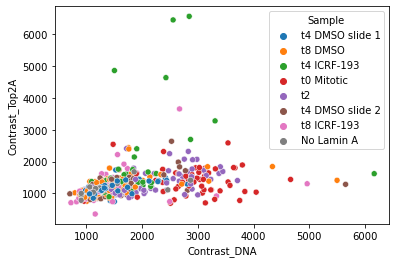

In [14]:
sns.scatterplot(data = image_features[image_features['Distance_DNA'] == 10], 
                x = 'Contrast_DNA', 
                y = 'Contrast_Top2A',
                hue = 'Sample'
               )

In [15]:
#Add Lamin A and nuclear size/shape info to each object

In [16]:
cytoplasm = pd.read_csv(f'{inDataDir}/210930_DNAAndTop2A_SaveCropped_Texture_256levelsCytoplasm.csv')
nuclei = pd.read_csv(f'{inDataDir}/210930_DNAAndTop2A_SaveCropped_Texture_256levelsExpandedNuclei_2pixels.csv')

In [17]:
#Add cytoplasm LaminA intensity to each nucleus - should be fine to just add by index, since 
#should be in same order and 1:1 correspondance.
nuclei['Cytoplasm_Intensity_MeanIntensity_LaminA'] = cytoplasm['Intensity_MeanIntensity_LaminA']

In [18]:
nuclei['Nuc_Cyt_LaminA_Ratio'] = nuclei['Intensity_MeanIntensity_LaminA']/nuclei['Cytoplasm_Intensity_MeanIntensity_LaminA']

In [26]:
list(nuclei.columns)

['ImageNumber',
 'ObjectNumber',
 'Metadata_C',
 'Metadata_ChannelName',
 'Metadata_ColorFormat',
 'Metadata_Date',
 'Metadata_Experiment',
 'Metadata_FileLocation',
 'Metadata_FileLocation.1',
 'Metadata_Frame',
 'Metadata_Image',
 'Metadata_Plate',
 'Metadata_Series',
 'Metadata_Site',
 'Metadata_SizeC',
 'Metadata_SizeT',
 'Metadata_SizeX',
 'Metadata_SizeY',
 'Metadata_SizeZ',
 'Metadata_Slide',
 'Metadata_T',
 'Metadata_Well',
 'Metadata_Z',
 'FileName_CytoplasmImage',
 'FileName_DNA',
 'FileName_LaminA',
 'FileName_NucleiImage',
 'FileName_OrigDNA',
 'FileName_OrigLaminA',
 'FileName_OrigTop2A',
 'FileName_Top2A',
 'PathName_CytoplasmImage',
 'PathName_DNA',
 'PathName_LaminA',
 'PathName_NucleiImage',
 'PathName_OrigDNA',
 'PathName_OrigLaminA',
 'PathName_OrigTop2A',
 'PathName_Top2A',
 'Children_Cytoplasm_Count',
 'Intensity_IntegratedIntensityEdge_LaminA',
 'Intensity_IntegratedIntensity_LaminA',
 'Intensity_LowerQuartileIntensity_LaminA',
 'Intensity_MADIntensity_LaminA',
 '

In [28]:
list(image_features.columns)

['AngularSecondMoment_DNA',
 'Contrast_DNA',
 'Correlation_DNA',
 'Variance_DNA',
 'InverseDifferenceMoment_DNA',
 'SumAverage_DNA',
 'SumVariance_DNA',
 'SumEntropy_DNA',
 'Entropy_DNA',
 'DifferenceVariance_DNA',
 'DifferenceEntropy_DNA',
 'InfoMeas1_DNA',
 'InfoMeas2_DNA',
 'ImagePath_DNA',
 'Distance_DNA',
 'InputDir_DNA',
 'ImageDir_DNA',
 'FileName',
 'Stain_DNA',
 'SlideNum',
 'ImageNum',
 'Sample',
 'AngularSecondMoment_Top2A',
 'Contrast_Top2A',
 'Correlation_Top2A',
 'Variance_Top2A',
 'InverseDifferenceMoment_Top2A',
 'SumAverage_Top2A',
 'SumVariance_Top2A',
 'SumEntropy_Top2A',
 'Entropy_Top2A',
 'DifferenceVariance_Top2A',
 'DifferenceEntropy_Top2A',
 'InfoMeas1_Top2A',
 'InfoMeas2_Top2A',
 'ImagePath_Top2A',
 'Distance_Top2A',
 'InputDir_Top2A',
 'ImageDir_Top2A',
 'Stain_Top2A']

In [59]:
#Split filename at /, then split SlideDir 
nuclei[['Metadata_Experiment', 'SlideNum', 'ImageNum']] = nuclei['FileName_DNA'].str.split('_', expand = True).iloc[:, 1:4]
image_features['ObjectNumber'] = image_features['FileName'].str.split('_', expand = True).iloc[:, 1].str.split('.', expand = True).iloc[:, 0]

In [53]:
nuclei[['SlideNum', 'ImageNum', 'Metadata_Experiment', 'ObjectNumber', 'Nuc_Cyt_LaminA_Ratio']]

,SlideNum,ImageNum,Metadata_Experiment,ObjectNumber,Nuc_Cyt_LaminA_Ratio
0,Slide1,001,exp512,1,1.251687
1,Slide1,001,exp512,2,1.265042
2,Slide1,001,exp512,3,1.371137
3,Slide1,002,exp512,1,0.920670
4,Slide1,003,exp512,1,0.829887
...,...,...,...,...,...
507,Slide9,031,exp512,3,2.762002
508,Slide9,032,exp512,1,5.879807
509,Slide9,033,exp512,1,3.438646
510,Slide9,033,exp512,2,3.287875


In [60]:
image_features[['SlideNum', 'ImageNum', 'FileName', 'ObjectNumber']]

,SlideNum,ImageNum,FileName,ObjectNumber
0,Slide2,022,Nuclei_2.tiff,2
1,Slide2,022,Nuclei_2.tiff,2
2,Slide2,022,Nuclei_1.tiff,1
3,Slide2,022,Nuclei_1.tiff,1
4,Slide2,022,Nuclei_2.tiff,2
...,...,...,...,...
34267,Slide2,004,Nuclei_4.tiff,4
34268,Slide2,004,Nuclei_1.tiff,1
34269,Slide2,004,Nuclei_1.tiff,1
34270,Slide2,004,Nuclei_1.tiff,1


In [65]:
image_features = image_features.drop(columns = ['Metadata_Experiment', 'Nuc_Cyt_LaminA_Ratio'])

In [68]:
image_features = image_features.astype({'ObjectNumber': 'int64'})

In [69]:
#Add nuclei['Nuc_Cyt_LaminA_Ratio'] to image_features
image_features2 = image_features.merge(nuclei[['SlideNum', 'ImageNum', 'ObjectNumber', 'Metadata_Experiment', 'Nuc_Cyt_LaminA_Ratio']], on = ['SlideNum', 'ImageNum', 'ObjectNumber'])


In [70]:
image_features = image_features2

In [81]:
image_features = image_features.drop_duplicates().reset_index(drop = True)

In [82]:
#Find nuclei with contrast near median for each sample to show as representative examples
representative_images_means = image_features.groupby(['Sample', 'Distance_DNA']).agg('median')

In [83]:
representative_images_means

AngularSecondMoment_DNA  Contrast_DNA  \
Sample      Distance_DNA                                          
No Lamin A  1                            0.000224    174.601202   
            2                            0.000192    264.582044   
            3                            0.000170    376.525097   
            4                            0.000160    503.710247   
            5                            0.000150    637.721333   
...                                           ...           ...   
t8 ICRF-193 20                           0.000130   1945.193284   
            21                           0.000131   1973.762438   
            22                           0.000131   2001.196137   
            23                           0.000132   2020.514521   
            24                           0.000133   2042.382775   

                          Correlation_DNA  Variance_DNA  \
Sample      Distance_DNA                                  
No Lamin A  1                    0.931432   1354.078536   
            2                    0.898978   1318.976707   
            3                    0.851414   1295.151241   
            4                    0.791059   1278.231791   
            5                    0.735043   1265.324540   
...                                   ...           ...   
t8 ICRF-193 20                   0.146613   1133.428016   
            21                   0.136875   1139.362011   
            22                   0.126896   1146.680349   
            23                   0.116766   1154.385662   
            24                   0.108934   1161.673279   

                          InverseDifferenceMoment_DNA  SumAverage_DNA  \
Sample      Distance_DNA                                                
No Lamin A  1                                0.091852      263.506402   
            2                                0.077434      264.684011   
            3                                0.067125      265.733785   
            4                                0.058134      266.677702   
            5                                0.051956      267.543813   
...                                               ...             ...   
t8 ICRF-193 20                               0.029001      252.298424   
            21                               0.028542      252.370592   
            22                               0.027964      252.407246   
            23                               0.027983      252.426805   
            24                               0.027939      252.419375   

                          SumVariance_DNA  SumEntropy_DNA  Entropy_DNA  \
Sample      Distance_DNA                                                 
No Lamin A  1                 5284.935638        8.172652    12.444942   
            2                 5033.783489        8.142057    12.698463   
            3                 4800.048286        8.111450    12.868709   
            4                 4597.031314        8.080201    12.965199   
            5                 4415.944596        8.051483    13.042335   
...                                   ...             ...          ...   
t8 ICRF-193 20                2634.399522        7.687345    13.189553   
            21                2616.997852        7.676995    13.182546   
            22                2589.228519        7.662925    13.175300   
            23                2552.524764        7.653929    13.165271   
            24                2527.646231        7.646369    13.149831   

                          DifferenceVariance_DNA  ...  SumVariance_Top2A  \
Sample      Distance_DNA                          ...                      
No Lamin A  1                           0.000150  ...        4383.665596   
            2                           0.000121  ...        4219.223257   
            3                           0.000101  ...        4070.035253   
            4                           0.000086  ...        3930.066441   
            5    

In [84]:
representative_images_means.loc['t8 ICRF-193', 10]['Contrast_DNA']

1394.6747769987082

In [85]:
representative_images = pd.DataFrame()
for cond in ['t0 Mitotic', 't2', 't4 DMSO slide 1', 't4 DMSO slide 2', 't4 ICRF-193', 't8 DMSO', 't8 ICRF-193']:
    nucdf = image_features[(image_features['Sample'] == cond) & (image_features['Distance_DNA'] == 10)]
    nucdf['Contrast_DNA_10_Avg_DifferenceFromMean'] = np.abs(nucdf['Contrast_DNA'] - representative_images_means.loc[cond, 10]['Contrast_DNA'])
    nucdf_min = nucdf[nucdf['Contrast_DNA_10_Avg_DifferenceFromMean'] == np.min(nucdf['Contrast_DNA_10_Avg_DifferenceFromMean'])]
    representative_images = representative_images.append(nucdf_min)

/var/folders/8b/r363wpj923z0t4jvjlp76gz80000gp/T/ipykernel_48167/1441575550.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nucdf['Contrast_DNA_10_Avg_DifferenceFromMean'] = np.abs(nucdf['Contrast_DNA'] - representative_images_means.loc[cond, 10]['Contrast_DNA'])


In [86]:
representative_images[['Sample', 'ImageDir_DNA', 'FileName', 'Contrast_DNA', 'Contrast_DNA_10_Avg_DifferenceFromMean', 'Nuc_Cyt_LaminA_Ratio']]

,Sample,ImageDir_DNA,FileName,Contrast_DNA,Contrast_DNA_10_Avg_DifferenceFromMean,Nuc_Cyt_LaminA_Ratio
9777,t0 Mitotic,Nuclei_Images_DNA_Slide4_018,Nuclei_1.tiff,3018.587229,0.000000,0.753339
2985,t2,Nuclei_Images_DNA_Slide5_030,Nuclei_1.tiff,2062.723071,0.000000,1.214692
6033,t4 DMSO slide 1,Nuclei_Images_DNA_Slide2_026,Nuclei_2.tiff,1438.862339,4.581562,8.170502
6273,t4 DMSO slide 1,Nuclei_Images_DNA_Slide2_017,Nuclei_2.tiff,1448.025463,4.581562,5.850127
11601,t4 DMSO slide 2,Nuclei_Images_DNA_Slide6_005,Nuclei_2.tiff,1453.067029,0.000000,10.579238
5289,t4 ICRF-193,Nuclei_Images_DNA_Slide7_030,Nuclei_1.tiff,1651.680585,0.000000,6.320460
3969,t8 DMSO,Nuclei_Images_DNA_Slide8_018,Nuclei_3.tiff,1417.073117,0.188170,0.932035
7665,t8 DMSO,Nuclei_Images_DNA_Slide8_009,Nuclei_2.tiff,1416.696776,0.188170,1.606429
8625,t8 ICRF-193,Nuclei_Images_DNA_Slide9_030,Nuclei_2.tiff,1397.814793,3.140016,4.683695


In [88]:
#save dataframe of image_features from all images
image_features.to_csv(f'{outDataDir}/211203_image_features_withLaminARatio.csv', index = False, header = True)

In [90]:
representative_images.to_csv(f'{outDataDir}/211203_RepresentativeImages_DNA.txt', sep = '\t', index = False, header = True)

In [92]:
#Find nuclei with overlap near median for each sample to show as representative examples
representative_images_means = image_features.groupby(['Sample', 'Distance_Top2A']).agg('mean')

In [93]:
representative_images_means

AngularSecondMoment_DNA  Contrast_DNA  \
Sample      Distance_Top2A                                          
No Lamin A  1                              0.000228    169.840405   
            2                              0.000197    269.145376   
            3                              0.000175    404.532276   
            4                              0.000161    558.430048   
            5                              0.000150    719.470986   
...                                             ...           ...   
t8 ICRF-193 20                             0.000133   2065.288505   
            21                             0.000133   2109.815109   
            22                             0.000134   2153.922352   
            23                             0.000134   2196.756585   
            24                             0.000135   2237.203592   

                            Correlation_DNA  Variance_DNA  \
Sample      Distance_Top2A                                  
No Lamin A  1                      0.932795   1400.910692   
            2                      0.895605   1366.113407   
            3                      0.844569   1342.516799   
            4                      0.786239   1326.822704   
            5                      0.725034   1316.418802   
...                                     ...           ...   
t8 ICRF-193 20                     0.164872   1234.750105   
            21                     0.149515   1237.096473   
            22                     0.134532   1239.538521   
            23                     0.120210   1242.020848   
            24                     0.106847   1244.325073   

                            InverseDifferenceMoment_DNA  SumAverage_DNA  \
Sample      Distance_Top2A                                                
No Lamin A  1                                  0.094768      264.393782   
            2                                  0.077177      265.941473   
            3                                  0.065096      267.274546   
            4                                  0.056630      268.426642   
            5                                  0.050232      269.431245   
...                                                 ...             ...   
t8 ICRF-193 20                                 0.029406      250.410412   
            21                                 0.028880      250.457808   
            22                                 0.028528      250.487626   
            23                                 0.028289      250.495183   
            24                                 0.027972      250.479630   

                            SumVariance_DNA  SumEntropy_DNA  Entropy_DNA  \
Sample      Distance_Top2A                                                 
No Lamin A  1                   5433.802365        8.130842    12.443798   
            2                   5195.308252        8.105466    12.663947   
            3                   4965.534920        8.077893    12.830249   
            4                   4748.860768        8.049443    12.951854   
            5                   4546.204221        8.021092    13.040946   
...                                     ...             ...          ...   
t8 ICRF-193 20                  2873.711914        7.688020    13.194691   
            21                  2838.570783        7.679892    13.188810   
            22                  2804.231732        7.671593    13.181873   
            23                  2771.326806        7.663948    13.174687   
            24                  2740.096702        7.656692    13.166040   

                            DifferenceVariance_DNA  ...  SumAverage_Top2A  \
Sample      Distance_Top2A                          ...                     
No Lamin A  1                             0.000155  ...        266.308143   
            2                             0.000122  ...        267.659036   
            3                             0.000099  ...        

In [94]:
representative_images_means.loc['t8 ICRF-193', 10]['Contrast_Top2A']

1199.2060521250949

In [95]:
representative_images = pd.DataFrame()
for cond in ['t0 Mitotic', 't2', 't4 DMSO slide 1', 't4 DMSO slide 2', 't4 ICRF-193', 't8 DMSO', 't8 ICRF-193']:
    nucdf = image_features[(image_features['Sample'] == cond) & (image_features['Distance_Top2A'] == 10)]
    nucdf['Contrast_Top2A_10_Avg_DifferenceFromMean'] = np.abs(nucdf['Contrast_Top2A'] - representative_images_means.loc[cond, 10]['Contrast_Top2A'])
    nucdf_min = nucdf[nucdf['Contrast_Top2A_10_Avg_DifferenceFromMean'] == np.min(nucdf['Contrast_Top2A_10_Avg_DifferenceFromMean'])]
    representative_images = representative_images.append(nucdf_min)

/var/folders/8b/r363wpj923z0t4jvjlp76gz80000gp/T/ipykernel_48167/3327775102.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nucdf['Contrast_Top2A_10_Avg_DifferenceFromMean'] = np.abs(nucdf['Contrast_Top2A'] - representative_images_means.loc[cond, 10]['Contrast_Top2A'])


In [96]:
representative_images[['Sample', 'ImageDir_Top2A', 'FileName', 'Contrast_Top2A', 'Contrast_Top2A_10_Avg_DifferenceFromMean']]

,Sample,ImageDir_Top2A,FileName,Contrast_Top2A,Contrast_Top2A_10_Avg_DifferenceFromMean
2001,t0 Mitotic,Nuclei_Images_Top2A_Slide4_023,Nuclei_1.tiff,1408.169365,0.803594
10689,t2,Nuclei_Images_Top2A_Slide5_002,Nuclei_1.tiff,1329.105116,26.909050
6249,t4 DMSO slide 1,Nuclei_Images_Top2A_Slide2_017,Nuclei_3.tiff,1182.566847,0.418686
8433,t4 DMSO slide 2,Nuclei_Images_Top2A_Slide6_010,Nuclei_1.tiff,1237.184509,4.617518
7737,t4 ICRF-193,Nuclei_Images_Top2A_Slide7_029,Nuclei_1.tiff,1748.952219,18.070454
3873,t8 DMSO,Nuclei_Images_Top2A_Slide8_020,Nuclei_2.tiff,1242.165158,2.498344
11193,t8 ICRF-193,Nuclei_Images_Top2A_Slide9_014,Nuclei_3.tiff,1210.491684,11.285632


In [97]:
representative_images.to_csv(f'{outDataDir}/211203_RepresentativeImages_Top2A.txt', sep = '\t', index = False, header = True)